### Processes raw data to sleep/wake segments + exports
Custom code required for each day due to different sleep/wake times

In [1]:
# imports
import numpy as np
import h5py 
import math 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
# options
save_on = 1
plot_on = 0
day = 7
# subj_id = 'a0f66459'
subj_id = 'cb46fd46'

In [3]:
# load raw data

filename = r"C:\Users\sunh20\Documents\Projects\SleepClass_SS\DATA\\" + subj_id + "\ecog\processed_" + subj_id + "_" + str(day) + ".h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))
ecog_d = fin.get('dataset')
fs = int(fin.get('f_sample')[()])
chan_label = fin.get('chanLabels')


['Kurt_channels', 'SD_channels', 'allChanArtifactInds', 'chanLabels', 'dataset', 'f_sample', 'goodChanInds', 'standardizeDenoms', 'start_timestamp', 'start_timestamp_nw']


In [5]:
# get grid + channel data
# first index = event data (ignore)
ECOG_data = ecog_d[1:65,].transpose();
print('ECOG_data:',ECOG_data.shape)

chan = np.arange(1,65)

if subj_id == 'a0f66459':
    # remove ch 37 (bad channel) + make list of channels
    chan = np.delete(chan,37-1)

    ECOG_data = np.delete(ECOG_data,37-1,1)

    print('Removed channel 37')
    print('ECOG_data:', ECOG_data.shape)
    print(chan)

ECOG_data: (41340362, 64)


In [4]:
# check start time - make sure it lines up with video times
import datetime
print('start time:')
print(datetime.datetime.utcfromtimestamp(fin.get('start_timestamp')[()]))

start time:
2015-04-03 08:09:03


In [7]:
# get sleep and wake times - depending on day
# can get 8 hours for days 6,7, only 6 hours for day 8

def get_seconds(hr,mn,sd):
    '''
    input hour, min, second as integers
    returns time in seconds from 00:00 (midnight)
    '''
    return hr*60*60 + mn*60 + sd

if subj_id == 'cb46fd46':
    if day == 7:
        t_start = get_seconds(8,9,3)
        t_wake = get_seconds(9,38,15) # 9:38:15 for 8 hours
        t_sleep = get_seconds(24,0,0) + get_seconds(3,6,12) # 3:06:12 for 4 hours
        t = np.arange(0,60*60*8,1/fs)  # 8 hours of data
    else:
        print('day not supported for subj %s' % subj_id)
elif subj_id == 'a0f66459':
    if day == 6:
        # video start time
        t_start = get_seconds(8,13,24)

        # get sleep and wake times
        t_wake = get_seconds(8,59,36) # 8:59:36 for 8 hours
        t_sleep = get_seconds(20,49,37) # 20:49:37 for 8 hours
        t = np.arange(0,60*60*8,1/fs)  # 8 hours of data
    elif day == 7:
        t_start = get_seconds(7,46,27)
        t_wake = get_seconds(9,19,17) # 9:19:17 for 12 hours
        t_sleep = get_seconds(22,11,16) # 22:11:16 for 8 hours
        t = np.arange(0,60*60*8,1/fs)  # 8 hours of data
    elif day == 8:
        t_start = get_seconds(8,0,21)
        t_wake = get_seconds(12,14,27) # 12:14:27 for 6 hours
        t_sleep = get_seconds(21,4,27) # 21:04:27 for 11 hours
        t = np.arange(0,60*60*6,1/fs)  # 6 hours of data
    else:
        print('day not supported for subj %s' % subj_id)
else:
    print('subj %s not supported' % subj_id)

# adjust to get start indices for wake + sleep
t_wake = (int)((t_wake - t_start)*fs)
t_sleep = (int)((t_sleep - t_start)*fs)

data_wake = ECOG_data[t_wake:t_wake+fs*math.ceil(t[-1]),]
data_sleep = ECOG_data[t_sleep:t_sleep+fs*math.ceil(t[-1]),]

print('t:',t.shape)
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

t: (14400000,)
data_wake: (14400000, 64)
data_sleep: (7225862, 64)


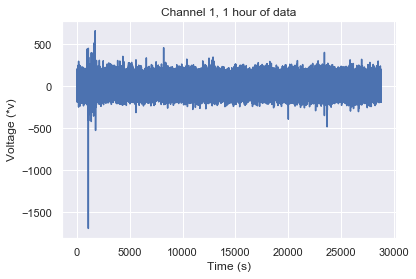

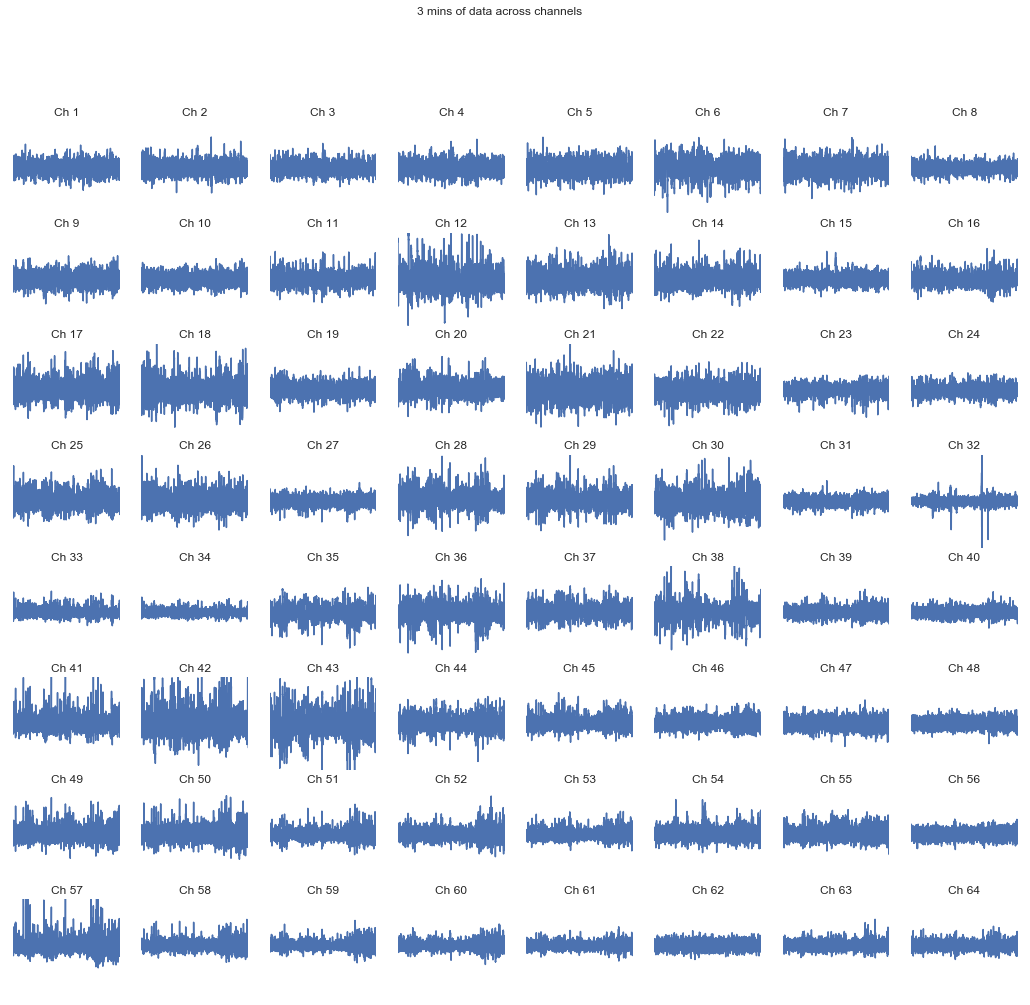

In [9]:
# visualize data (1 channel)

if plot_on:
    plt.figure
    plt.plot(t,data_wake[:,0])
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (*v)')
    plt.title('Channel 1, 1 hour of data')

    # visualize all channels
    plt.figure(figsize=(18,16))
    plt.suptitle('3 mins of data across channels')
    for ch in range(chan.shape[0]):
        plt.subplot(8,8,ch+1)
        plt.box(False)
        plt.plot(t[0:90000],data_wake[0:90000,ch])
        plt.axis([0, 60, -400, 400])
        plt.title('Ch ' + str(chan[ch]))
        plt.xticks(ticks=[], labels=[])
        plt.yticks(ticks=[], labels=[])

In [12]:
# save data 
# 8 hr for day 6,7
# 6 hr for day 8
if save_on:
    outname = "" + subj_id + "_d" + str(day) + "_sleepwake.h5"
    with h5py.File(outname,'w') as f:
        f.create_dataset("wake_d", data=data_wake)
        f.create_dataset("sleep_d", data=data_sleep)
        f.create_dataset('t',data=t)
        f.create_dataset('chan',data=chan)
    print('saving completed')